In [1]:
# # For Sentinel-2
# # !pip install sentinelsat
# import sys
# !{sys.executable} -m pip install sentinelsat

In [2]:
import ee
import geemap
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Function to compute NDVI
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8','B4']).rename('NDVI')
    return image.addBands(ndvi)


# Reduce over vineyard to get mean NDVI per date
def reduce_region(image, geom, plot_id):
    mean_ndvi = image.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=10
    )
    return ee.Feature(None, {
        'date': image.date().format(),
        'plot_id': plot_id,
        'mean_ndvi': mean_ndvi.get('NDVI')
    })

In [4]:
# ee.Authenticate()
ee.Initialize()

# Load your vineyard polygon (GeoJSON)
vineyard = gpd.read_file("data/polygons/RegressionRidge_smol.geojson")
# geom = ee.Geometry.Polygon(list(vineyard.geometry[0].exterior.coords))
# Assuming vineyard has 65 polygons
geoms = [ee.Geometry.Polygon(list(p.exterior.coords)) for p in vineyard.geometry]


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [5]:
years = [str(year) for year in range(2014, 2025, 1)]
months = ['01', '12']
days = ['01', '31']
start_dates = [year + '-' + months[0] + '-' + days[0] for year in years]
end_dates = [year + '-' + months[1] + '-' + days[1] for year in years]

In [6]:
for start_date, end_date in tqdm(zip(start_dates, end_dates), total=len(start_dates)):
    fname = f"data/ndvi/plots/ndvi_{start_date}_to_{end_date}.pkl"
    if os.path.isfile(fname):
        continue

    collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                  .filterBounds(geoms[0])  # bounds of all plots could be unioned
                  .filterDate(start_date, end_date)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
                  .select(['B4','B8']))
    
    collection = collection.map(add_ndvi)
    
    features = []
    for i, geom in enumerate(geoms):
        ndvi_ts = collection.map(lambda img: reduce_region(img, geom, i))
        features.extend(ndvi_ts.getInfo()['features'])

    # Convert to DataFrame
    df = pd.DataFrame({
        'date': [f['properties']['date'] for f in features],
        'plot_id': [f['properties']['plot_id'] for f in features],
        'ndvi': [f['properties']['mean_ndvi'] for f in features]
    })
    
    os.makedirs("data/ndvi/plots", exist_ok=True)
    df.to_pickle(fname)


100%|██████████| 11/11 [00:00<00:00, 14027.77it/s]


In [7]:
df_list = []
empties = []
for file in tqdm(os.listdir('data/ndvi/plots')):
    if file == 'agg_stats.pkl':
        continue
    # print(file)
    if file == '.ipynb_checkpoints':
        continue
    if file == 'plots':
        continue
    if file == 'ndvi_df.pkl':
        continue
    df = pd.read_pickle(os.path.join('data/ndvi/plots', file))
    if df.empty:
        # print('empty')
        empties.append(file)
        
        continue
        
    # df = df[(df['date'].dt.dayofyear >= 90) & (df['date'].dt.dayofyear <= 300)]
    df['ndvi_smooth'] = df['ndvi'].rolling(window=5, center=True, min_periods=1).mean()

    df_list.append(df)

df = pd.concat(df_list, axis = 0)

100%|██████████| 14/14 [00:00<00:00, 486.96it/s]


Okay, we have a df per plot time series of ndvi

In [8]:
df['year'] = pd.to_datetime(df['date']).dt.year

stats = []
for key, group in df.groupby('plot_id'):
    # print(key, group)
    for yr, data in group.groupby('year'):
        # print(data)
        variance = np.var(data['ndvi'])
        mean = np.mean(data['ndvi'])
        n = len(data['ndvi'])
        stats.append({
            'year':yr,
            'plot':key,
            'mean':mean,
            'variance':variance,
            'n':n
        })
ndvi_stats = pd.DataFrame(stats)

In [9]:
ndvi_stats_gdf = ndvi_stats.merge(
    vineyard[['geometry']],  # keep just geometry
    left_on='plot',
    right_index=True
)

In [10]:
ndvi_stats_gdf

,year,plot,mean,variance,n,geometry
0,2016,0,0.258056,0.003258,8,"POLYGON ((-119.78490 45.87348, -119.78391 45.8..."
1,2017,0,0.278854,0.015198,6,"POLYGON ((-119.78490 45.87348, -119.78391 45.8..."
2,2018,0,0.279461,0.005102,14,"POLYGON ((-119.78490 45.87348, -119.78391 45.8..."
3,2019,0,0.325010,0.009693,62,"POLYGON ((-119.78490 45.87348, -119.78391 45.8..."
4,2020,0,0.317714,0.004256,66,"POLYGON ((-119.78490 45.87348, -119.78391 45.8..."
...,...,...,...,...,...,...
580,2020,64,0.348972,0.005100,66,"POLYGON ((-119.77954 45.87530, -119.77952 45.8..."
581,2021,64,0.358084,0.006088,67,"POLYGON ((-119.77954 45.87530, -119.77952 45.8..."
582,2022,64,0.316522,0.010697,59,"POLYGON ((-119.77954 45.87530, -119.77952 45.8..."
583,2023,64,0.309874,0.006251,56,"POLYGON ((-119.77954 45.87530, -119.77952 45.8..."


In [11]:
across_year = (
    ndvi_stats
    .groupby('plot')
    .agg(
        mean_of_means=('mean', 'mean'),
        var_of_means=('mean', 'var'),
        mean_of_variance=('variance', 'mean')
    )
)


In [12]:
across_year.to_pickle('data/ndvi/plots/agg_stats.pkl')

In [13]:
aligned_dfs = []
for df in df_list:
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['doy'] = df['date'].dt.dayofyear
    # optional: keep only growing season
    df = df[(df['doy'] >= 90) & (df['doy'] <= 300)]
    
    # Aggregate multiple observations per day
    df_daily = df.groupby('doy')['ndvi_smooth'].mean().reset_index()
    
    year = df['date'].dt.year.iloc[0]
    df_daily.rename(columns={'ndvi_smooth': year}, inplace=True)
    aligned_dfs.append(df_daily)


In [14]:
from functools import reduce

df_all = reduce(lambda left, right: pd.merge(left, right, on='doy', how='outer'), aligned_dfs)
df_all.set_index('doy', inplace=True)

# Sort by DOY to get a proper seasonal curve
df_all.sort_index(inplace=True)


In [15]:
df_all

,2016,2023,2020,2017,2022,2018,2019,2021,2024
doy,,,,,,,,,
90,NaN,NaN,NaN,NaN,NaN,NaN,0.278986,NaN,NaN
92,NaN,NaN,NaN,NaN,0.179456,NaN,NaN,NaN,0.184459
97,NaN,NaN,NaN,NaN,0.186549,NaN,NaN,NaN,NaN
99,0.221011,NaN,NaN,NaN,NaN,NaN,NaN,0.220364,NaN
100,NaN,NaN,0.250783,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
289,NaN,NaN,NaN,NaN,0.322948,NaN,NaN,0.434171,NaN
292,NaN,0.257261,NaN,NaN,0.317484,NaN,NaN,0.402480,NaN
295,NaN,NaN,0.288934,NaN,NaN,0.245761,0.334046,NaN,NaN


In [16]:
mean_ndvi = df_all.mean(axis=1)
std_ndvi = df_all.std(axis=1)
n_years = df_all.shape[1]

ci_upper = mean_ndvi + 1.96 * std_ndvi / np.sqrt(n_years)
ci_lower = mean_ndvi - 1.96 * std_ndvi / np.sqrt(n_years)


In [17]:
window = 15  # days
mean_smooth = mean_ndvi.rolling(window, center=True, min_periods=1).mean()
ci_upper_smooth = ci_upper.rolling(window, center=True, min_periods=1).mean()
ci_lower_smooth = ci_lower.rolling(window, center=True, min_periods=1).mean()


In [18]:
doy_grid = np.arange(1, 366)  # 1 to 365


year_arrays = []

for df in df_list:
    df = df.copy()
    df['doy'] = pd.to_datetime(df['date']).dt.dayofyear
    # Drop duplicate DOYs to avoid reindexing errors
    df = df.drop_duplicates(subset='doy')
    
    # Interpolate onto full grid
    s = pd.Series(df['ndvi_smooth'].values, index=df['doy'])
    s_interp = s.reindex(doy_grid).interpolate(method='linear', limit_direction='both')
    year_arrays.append(s_interp.values)

In [19]:
year_matrix = np.vstack(year_arrays)  # shape: (n_years, 365)

# Compute mean and standard deviation across years
mean_ndvi = np.nanmean(year_matrix, axis=0)
std_ndvi = np.nanstd(year_matrix, axis=0)

# Smooth with rolling window
window = 15  # roughly 2 weeks
mean_smooth = pd.Series(mean_ndvi).rolling(window, center=True, min_periods=1).mean().values
std_smooth = pd.Series(std_ndvi).rolling(window, center=True, min_periods=1).mean().values

# 95% confidence interval
ci_upper = mean_smooth + 1.96 * std_smooth
ci_lower = mean_smooth - 1.96 * std_smooth

/home/simonhans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/simonhans/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


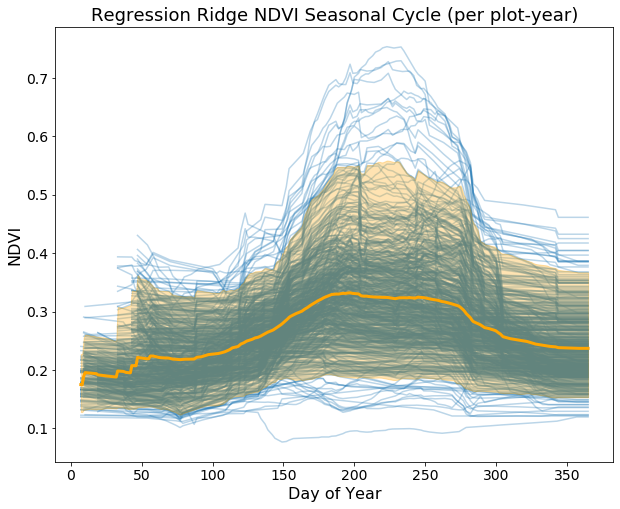

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

doy_full = np.arange(1, 366)
all_ndvi = []

plt.figure(figsize=(10, 8))

for df in df_list:
    df["date"] = pd.to_datetime(df["date"])
    df["ndvi_smooth"] = df["ndvi"].rolling(window=15, center=True, min_periods=1).mean()
    
    # Skip very low NDVI plots
    # if np.mean(df["ndvi_smooth"]) < 0.2:
    #     continue
    
    df["year"] = df["date"].dt.year
    df["doy"] = df["date"].dt.dayofyear
    plot_id = df.get("plot_id", None)
    
    # Group by plot and year
    if plot_id is not None:
        group_cols = ["plot_id", "year"]
    else:
        # fallback: treat entire df as one plot
        df["plot_id"] = 0
        group_cols = ["plot_id", "year"]
    
    for (p_id, year), group in df.groupby(group_cols):
        # Aggregate duplicates per DOY
        group_agg = group.groupby("doy", as_index=False)["ndvi_smooth"].mean()
        
        # Reindex to full DOY and interpolate missing values
        group_interp = group_agg.set_index("doy").reindex(doy_full)
        group_interp["ndvi_smooth"] = group_interp["ndvi_smooth"].interpolate()
        
        # Plot per plot-year
        label = f"Plot {p_id} - {year}"
        plt.plot(doy_full, group_interp["ndvi_smooth"], alpha=0.3, color='#1f77b4',)
        
        all_ndvi.append(group_interp["ndvi_smooth"].values)
        
# Compute mean and 95% CI across all plot-years
all_ndvi = np.array(all_ndvi)
mean_smooth = np.nanmean(all_ndvi, axis=0)
ci_lower = np.nanpercentile(all_ndvi, 2.5, axis=0)
ci_upper = np.nanpercentile(all_ndvi, 97.5, axis=0)

# Plot mean ± 95% CI
# plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.5, label='95% CI')
# plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, label='Mean NDVI (smoothed)')
plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.3, zorder=3)
plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, zorder=2)
# for df_values in all_ndvi:
#     plt.plot(doy_full, df_values, alpha=0.3, color='#1f77b4', zorder=3)
plt.xlabel("Day of Year", fontsize=16)
plt.ylabel("NDVI", fontsize=16)
plt.title("Regression Ridge NDVI Seasonal Cycle (per plot-year)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=12, loc="upper left")
plt.savefig('fig.png')
plt.show()


In [21]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# doy_full = np.arange(1, 366)
# all_ndvi = []

# plt.figure(figsize=(10, 8))

# # Collect all peak NDVI values for outlier filtering later
# all_peaks = []

# for df in df_list:
#     df["date"] = pd.to_datetime(df["date"])
#     df["ndvi_smooth"] = df["ndvi"].rolling(window=15, center=True, min_periods=1).mean()
#     df["year"] = df["date"].dt.year
#     df["doy"] = df["date"].dt.dayofyear
    
#     plot_id = df.get("plot_id", None)
#     if plot_id is not None:
#         group_cols = ["plot_id", "year"]
#     else:
#         df["plot_id"] = 0
#         group_cols = ["plot_id", "year"]

#     for (p_id, year), group in df.groupby(group_cols):
#         # Aggregate duplicates per DOY
#         group_agg = group.groupby("doy", as_index=False)["ndvi_smooth"].mean()
#         group_interp = group_agg.set_index("doy").reindex(doy_full)
#         group_interp["ndvi_smooth"] = group_interp["ndvi_smooth"].interpolate()

#         # === Filters ===
#         mean_ndvi = group_interp["ndvi_smooth"].mean()
#         peak_ndvi = group_interp["ndvi_smooth"].max()
#         amplitude = peak_ndvi - group_interp["ndvi_smooth"].min()

#         # Skip very low NDVI plots (already in your code)
#         if mean_ndvi < 0.2:
#             continue
#         # Skip flat/inactive curves (very small amplitude)
#         if amplitude < 0.1:  # tweak threshold as needed
#             continue

#         all_peaks.append(peak_ndvi)

#         # Plot per plot-year
#         label = f"Plot {p_id} - {year}"
#         plt.plot(doy_full, group_interp["ndvi_smooth"], alpha=0.3, color='#1f77b4')
#         all_ndvi.append(group_interp["ndvi_smooth"].values)

# # === Outlier filter (global, after loop) ===
# all_peaks = np.array(all_peaks)
# mean_peak, std_peak = np.nanmean(all_peaks), np.nanstd(all_peaks)
# lower_bound, upper_bound = mean_peak - 3*std_peak, mean_peak + 3*std_peak

# filtered_ndvi = []
# for ndvi_curve in all_ndvi:
#     peak = np.nanmax(ndvi_curve)
#     if lower_bound <= peak <= upper_bound:
#         filtered_ndvi.append(ndvi_curve)

# # Convert to array for summary
# all_ndvi = np.array(filtered_ndvi)
# mean_smooth = np.nanmean(all_ndvi, axis=0)
# ci_lower = np.nanpercentile(all_ndvi, 2.5, axis=0)
# ci_upper = np.nanpercentile(all_ndvi, 97.5, axis=0)

# # Plot mean ± 95% CI
# plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.3, zorder=3)
# plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, zorder=2)

# plt.xlabel("Day of Year", fontsize=16)
# plt.ylabel("NDVI", fontsize=16)
# plt.title("Regression Ridge NDVI Seasonal Cycle (per plot-year)", fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.savefig('fig.png')
# plt.show()


In [22]:
df_ndvi = pd.DataFrame({
    'doy': doy_grid,
    'mean_ndvi': mean_smooth,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

In [23]:
# df_ndvi.to_pickle('data/ndvi/plots/ndvi_df.pkl')

In [24]:
df_ndvi

,doy,mean_ndvi,ci_lower,ci_upper
0,1,NaN,NaN,NaN
1,2,NaN,NaN,NaN
2,3,NaN,NaN,NaN
3,4,NaN,NaN,NaN
4,5,NaN,NaN,NaN
...,...,...,...,...
360,361,0.237001,0.153335,0.367082
361,362,0.237001,0.153335,0.367082
362,363,0.237001,0.153335,0.367082
363,364,0.237001,0.153335,0.367082


In [25]:
ndvi = pd.DataFrame(all_ndvi)

In [26]:
ndvi.T

,0,1,2,3,4,5,6,7,8,9,...,575,576,577,578,579,580,581,582,583,584
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.249799,0.247388,0.241101,0.239443,0.233666,0.225226,0.199067,0.197032,0.233602,0.233561,...,0.19165,0.174715,0.169419,0.165658,0.204168,0.188673,0.238685,0.207897,0.228718,0.189062
361,0.249799,0.247388,0.241101,0.239443,0.233666,0.225226,0.199067,0.197032,0.233602,0.233561,...,0.19165,0.174715,0.169419,0.165658,0.204168,0.188673,0.238685,0.207897,0.228718,0.189062
362,0.249799,0.247388,0.241101,0.239443,0.233666,0.225226,0.199067,0.197032,0.233602,0.233561,...,0.19165,0.174715,0.169419,0.165658,0.204168,0.188673,0.238685,0.207897,0.228718,0.189062
363,0.249799,0.247388,0.241101,0.239443,0.233666,0.225226,0.199067,0.197032,0.233602,0.233561,...,0.19165,0.174715,0.169419,0.165658,0.204168,0.188673,0.238685,0.207897,0.228718,0.189062


In [27]:
ndvi

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.249799,0.249799,0.249799,0.249799,0.249799,0.249799,0.249799,0.249799,0.249799,0.249799
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.247388,0.247388,0.247388,0.247388,0.247388,0.247388,0.247388,0.247388,0.247388,0.247388
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.241101,0.241101,0.241101,0.241101,0.241101,0.241101,0.241101,0.241101,0.241101,0.241101
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.239443,0.239443,0.239443,0.239443,0.239443,0.239443,0.239443,0.239443,0.239443,0.239443
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.233666,0.233666,0.233666,0.233666,0.233666,0.233666,0.233666,0.233666,0.233666,0.233666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,NaN,NaN,NaN,NaN,NaN,NaN,0.195364,0.195240,0.195115,0.194991,...,0.188673,0.188673,0.188673,0.188673,0.188673,0.188673,0.188673,0.188673,0.188673,0.188673
581,NaN,NaN,NaN,NaN,NaN,NaN,0.179352,0.179247,0.179142,0.179037,...,0.238685,0.238685,0.238685,0.238685,0.238685,0.238685,0.238685,0.238685,0.238685,0.238685
582,NaN,NaN,NaN,NaN,NaN,NaN,0.223691,0.223539,0.223386,0.223234,...,0.207897,0.207897,0.207897,0.207897,0.207897,0.207897,0.207897,0.207897,0.207897,0.207897
583,NaN,NaN,NaN,NaN,NaN,NaN,0.197413,0.197266,0.197118,0.196971,...,0.228718,0.228718,0.228718,0.228718,0.228718,0.228718,0.228718,0.228718,0.228718,0.228718


In [28]:
years = list(range(2016, 2025))  # adjust as needed
rows_per_year = 65

for n, year in enumerate(years):
    start = n * rows_per_year
    end = (n + 1) * rows_per_year
    ndvi.loc[start:end-1, 'year'] = str(year)
    

In [29]:
ndvi

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.249799,0.249799,0.249799,0.249799,0.249799,0.249799,0.249799,0.249799,0.249799,2016
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.247388,0.247388,0.247388,0.247388,0.247388,0.247388,0.247388,0.247388,0.247388,2016
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.241101,0.241101,0.241101,0.241101,0.241101,0.241101,0.241101,0.241101,0.241101,2016
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.239443,0.239443,0.239443,0.239443,0.239443,0.239443,0.239443,0.239443,0.239443,2016
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.233666,0.233666,0.233666,0.233666,0.233666,0.233666,0.233666,0.233666,0.233666,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,NaN,NaN,NaN,NaN,NaN,NaN,0.195364,0.195240,0.195115,0.194991,...,0.188673,0.188673,0.188673,0.188673,0.188673,0.188673,0.188673,0.188673,0.188673,2024
581,NaN,NaN,NaN,NaN,NaN,NaN,0.179352,0.179247,0.179142,0.179037,...,0.238685,0.238685,0.238685,0.238685,0.238685,0.238685,0.238685,0.238685,0.238685,2024
582,NaN,NaN,NaN,NaN,NaN,NaN,0.223691,0.223539,0.223386,0.223234,...,0.207897,0.207897,0.207897,0.207897,0.207897,0.207897,0.207897,0.207897,0.207897,2024
583,NaN,NaN,NaN,NaN,NaN,NaN,0.197413,0.197266,0.197118,0.196971,...,0.228718,0.228718,0.228718,0.228718,0.228718,0.228718,0.228718,0.228718,0.228718,2024


In [30]:
rows_per_year = 65
years = list(range(2016, 2025))  # adjust to match your data
n_years = len(years)

# total rows should match your df
assert ndvi.shape[0] == rows_per_year * n_years

# assign year
ndvi['year'] = np.repeat(years, rows_per_year)

# assign plot_id (repeats 0..64 for each year)
ndvi['plot_id'] = np.tile(np.arange(rows_per_year), n_years)


In [31]:
import numpy as np
import pandas as pd

# Assume ndvi_df has columns: [0..364] for DOY, plus 'year', 'plot_id'

# Compute curve-level features
curve_stats = []
for idx, row in ndvi.iterrows():
    # Grab the first 365 columns (days of year NDVI values)
    ndvi_vals = row.iloc[0:365].astype(float).values

    # ignore NaNs
    ndvi_vals = ndvi_vals[~np.isnan(ndvi_vals)]
    if len(ndvi_vals) == 0:
        continue

    mean_val = np.mean(ndvi_vals)
    peak_val = np.max(ndvi_vals)
    min_val = np.min(ndvi_vals)
    amplitude = peak_val - min_val

    curve_stats.append({
        "index": idx,
        "mean": mean_val,
        "peak": peak_val,
        "amplitude": amplitude
    })

curve_stats = pd.DataFrame(curve_stats)

# === Define filters ===
mean_mean, mean_std = curve_stats["mean"].mean(), curve_stats["mean"].std()
mask_mean_outlier = ~curve_stats["mean"].between(mean_mean - 3.5*mean_std,
                                                 mean_mean + 3.5*mean_std)

peak_mean, peak_std = curve_stats["peak"].mean(), curve_stats["peak"].std()
mask_peak_outlier = ~curve_stats["peak"].between(peak_mean - 3.5*peak_std,
                                                 peak_mean + 3.5*peak_std)

mask_flat = curve_stats["amplitude"] < 0.1  # nearly flat curves

# Combine masks
bad_idx = curve_stats.loc[mask_mean_outlier | mask_peak_outlier | mask_flat, "index"]

# === Filter original wide table ===
ndvi_filtered = ndvi.drop(index=bad_idx)

print(f"Dropped {len(bad_idx)} outlier plot-years out of {len(ndvi)} total")


Dropped 222 outlier plot-years out of 585 total


In [32]:
ndvi_filtered

,0,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,year,plot_id
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.205640,0.205640,0.205640,0.205640,0.205640,0.205640,0.205640,0.205640,2017,0
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.198981,0.198981,0.198981,0.198981,0.198981,0.198981,0.198981,0.198981,2017,1
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.227761,0.227761,0.227761,0.227761,0.227761,0.227761,0.227761,0.227761,2017,2
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.215223,0.215223,0.215223,0.215223,0.215223,0.215223,0.215223,0.215223,2017,3
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.186880,0.186880,0.186880,0.186880,0.186880,0.186880,0.186880,0.186880,2017,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,NaN,NaN,NaN,NaN,NaN,NaN,0.195364,0.195240,0.195115,0.194991,...,0.188673,0.188673,0.188673,0.188673,0.188673,0.188673,0.188673,0.188673,2024,60
581,NaN,NaN,NaN,NaN,NaN,NaN,0.179352,0.179247,0.179142,0.179037,...,0.238685,0.238685,0.238685,0.238685,0.238685,0.238685,0.238685,0.238685,2024,61
582,NaN,NaN,NaN,NaN,NaN,NaN,0.223691,0.223539,0.223386,0.223234,...,0.207897,0.207897,0.207897,0.207897,0.207897,0.207897,0.207897,0.207897,2024,62
583,NaN,NaN,NaN,NaN,NaN,NaN,0.197413,0.197266,0.197118,0.196971,...,0.228718,0.228718,0.228718,0.228718,0.228718,0.228718,0.228718,0.228718,2024,63


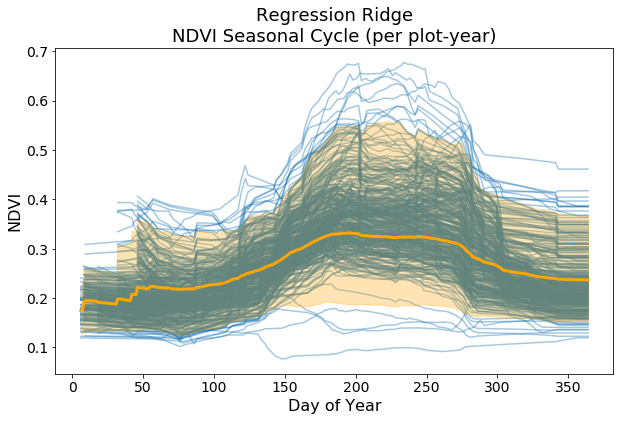

In [40]:
import matplotlib.pyplot as plt


plt.figure(figsize = (10,6))
# Extract DOY columns (all ints, except 'year')
doy_cols = [c for c in ndvi_filtered.columns if isinstance(c, (int, np.integer))]

# X-axis = DOY numbers
doy_full = np.arange(len(doy_cols))

# Loop through rows
for idx, row in ndvi_filtered.iterrows():
    year = row["year"]
    ndvi_values = row[doy_cols].values.astype(float)

    # skip all-NaN rows
    if np.isnan(ndvi_values).all():
        continue

    plt.plot(doy_full, ndvi_values, alpha=0.4, color="#1f77b4")

plt.xlabel("Day of Year")
plt.ylabel("NDVI (smoothed)")
plt.title("NDVI curves by plot-year")

plt.fill_between(doy_full, ci_lower, ci_upper, color='orange', alpha=0.3, zorder=3)
plt.plot(doy_full, mean_smooth, color='orange', linewidth=3, zorder=2)
# for df_values in all_ndvi:
#     plt.plot(doy_full, df_values, alpha=0.3, color='#1f77b4', zorder=3)
plt.xlabel("Day of Year", fontsize=16)
plt.ylabel("NDVI", fontsize=16)
plt.title("Regression Ridge\nNDVI Seasonal Cycle (per plot-year)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=12, loc="upper left")
plt.savefig('img/ndvi_spaghetti.png')
plt.show()
plt.show()


In [34]:
df_ndvi = pd.DataFrame({
    'doy': doy_grid,
    'mean_ndvi': mean_smooth,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

In [35]:
ndvi.to_pickle('data/plot_ndvi.pkl')

In [36]:
ndvi_filtered.to_pickle('data/plot_ndvi_filtered.pkl')